# Cluster GNN

Cluster-GCN works as the following: at each step, it samples a block of nodes that associate with a dense subgraph identified by a graph clustering algorithm, and restricts the neighborhood search within this subgraph.

Link : https://arxiv.org/abs/1905.07953

## Import Libraries

In [1]:
import torch
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures

## Util Functions

In [2]:
def data_details(dataset):
    print()
    print(f'Dataset: {dataset}:')
    print('====================')
    print(f'Number of graphs: {len(dataset)}')
    print(f'Number of features: {dataset.num_features}')
    print(f'Number of classes: {dataset.num_classes}')

def graph_details(data):
    print()
    print(data)
    print('=============================================================')
    
    # Gather some statistics about the first graph.
    print(f'Number of nodes: {data.num_nodes}')
    print(f'Number of edges: {data.num_edges}')
    print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
    print(f'Has isolated nodes: {data.has_isolated_nodes()}')
    print(f'Has self-loops: {data.has_self_loops()}')
    print(f'Is undirected: {data.is_undirected()}')   

In [3]:
dataset = Planetoid(root='data/Planetoid', name='PubMed', transform=NormalizeFeatures())
data = dataset[0]
data_details(dataset)
graph_details(dataset[0])


Dataset: PubMed():
Number of graphs: 1
Number of features: 500
Number of classes: 3

Data(x=[19717, 500], edge_index=[2, 88648], y=[19717], train_mask=[19717], val_mask=[19717], test_mask=[19717])
Number of nodes: 19717
Number of edges: 88648
Average node degree: 4.50
Has isolated nodes: False
Has self-loops: False
Is undirected: True


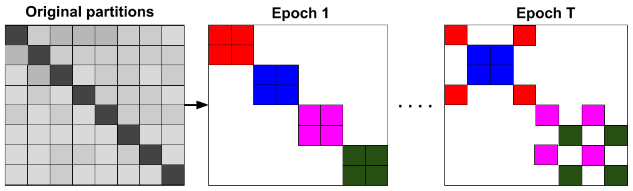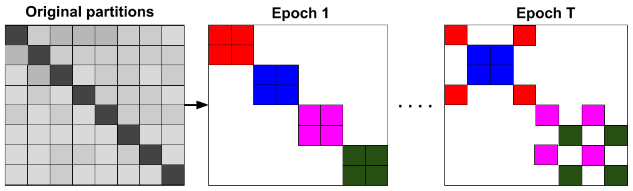

In [5]:
from torch_geometric.loader import ClusterData, ClusterLoader
torch.manual_seed(42)
cluster_data = ClusterData(data, num_parts=128)  # 1. Create subgraphs.
train_loader = ClusterLoader(cluster_data, batch_size=32, shuffle=True)  # 2. Stochastic partioning scheme.

Computing METIS partitioning...
Done!


In [9]:
for step, data in enumerate(train_loader):
    print(f'Step {step + 1}:')
    print('=======')
    print(f'Number of graphs in the current batch: {data.num_nodes}')
    print(data)
    print()

Step 1:
Number of graphs in the current batch: 4933
Data(x=[4933, 500], y=[4933], train_mask=[4933], val_mask=[4933], test_mask=[4933], edge_index=[2, 16746])

Step 2:
Number of graphs in the current batch: 4923
Data(x=[4923, 500], y=[4923], train_mask=[4923], val_mask=[4923], test_mask=[4923], edge_index=[2, 15282])

Step 3:
Number of graphs in the current batch: 4928
Data(x=[4928, 500], y=[4928], train_mask=[4928], val_mask=[4928], test_mask=[4928], edge_index=[2, 16306])

Step 4:
Number of graphs in the current batch: 4933
Data(x=[4933, 500], y=[4933], train_mask=[4933], val_mask=[4933], test_mask=[4933], edge_index=[2, 18604])



In [15]:
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(GCN, self).__init__()
        torch.manual_seed(12345)
        self.conv1 = GCNConv(data.num_node_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, dataset.num_classes)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        return x

model = GCN(hidden_channels=16)
print(model)

GCN(
  (conv1): GCNConv(500, 16)
  (conv2): GCNConv(16, 3)
)


In [16]:
model = GCN(hidden_channels=16)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()

def train():
      model.train()

      for sub_data in train_loader:  # Iterate over each mini-batch.
          out = model(sub_data.x, sub_data.edge_index)  # Perform a single forward pass.
          loss = criterion(out[sub_data.train_mask], sub_data.y[sub_data.train_mask])  # Compute the loss solely based on the training nodes.
          loss.backward()  # Derive gradients.
          optimizer.step()  # Update parameters based on gradients.
          optimizer.zero_grad()  # Clear gradients.

def test():

    model.eval()
    out = model(data.x, data.edge_index)
    pred = out.argmax(dim=1)  # Use the class with highest probability.
    accs = []

    for mask in [data.train_mask, data.val_mask, data.test_mask]:
        correct = pred[mask] == data.y[mask]  # Check against ground-truth labels.
        accs.append(int(correct.sum()) / int(mask.sum()))  # Derive ratio of correct predictions.

    return accs 

In [17]:
for epoch in range(1, 51):
    loss = train()
    train_acc, val_acc, test_acc = test()
    print(f'Epoch: {epoch:03d}, Train: {train_acc:.4f}, Val Acc: {val_acc:.4f}, Test Acc: {test_acc:.4f}')

Epoch: 001, Train: 0.2381, Val Acc: 0.3821, Test Acc: 0.3647
Epoch: 002, Train: 0.6190, Val Acc: 0.5122, Test Acc: 0.4510
Epoch: 003, Train: 0.9048, Val Acc: 0.7642, Test Acc: 0.6706
Epoch: 004, Train: 0.9048, Val Acc: 0.7561, Test Acc: 0.6706
Epoch: 005, Train: 0.9048, Val Acc: 0.7805, Test Acc: 0.6902
Epoch: 006, Train: 0.9048, Val Acc: 0.7724, Test Acc: 0.6667
Epoch: 007, Train: 0.9048, Val Acc: 0.7805, Test Acc: 0.6863
Epoch: 008, Train: 0.9048, Val Acc: 0.7805, Test Acc: 0.6980
Epoch: 009, Train: 0.9524, Val Acc: 0.7967, Test Acc: 0.7255
Epoch: 010, Train: 0.9524, Val Acc: 0.8049, Test Acc: 0.7373
Epoch: 011, Train: 0.9524, Val Acc: 0.7886, Test Acc: 0.7255
Epoch: 012, Train: 0.9524, Val Acc: 0.7967, Test Acc: 0.7216
Epoch: 013, Train: 0.9524, Val Acc: 0.7967, Test Acc: 0.7373
Epoch: 014, Train: 0.9524, Val Acc: 0.7967, Test Acc: 0.7333
Epoch: 015, Train: 0.9524, Val Acc: 0.8130, Test Acc: 0.7333
Epoch: 016, Train: 0.9524, Val Acc: 0.8455, Test Acc: 0.7569
Epoch: 017, Train: 0.952